# Table of Contents
* ##  General Exploratory Data Analysis

* ##  Preprocessing of the Tasks
    - Sliding days as 1D Tempreture Arrays to predict next day's Temperature (SDT)
    - Sliding windows with multiple columns to predict next day's Temperature [Done] (SWT)
    - Sliding windows with multiple columns to predict next day's Daily Summary (SWS) [Done]


* ##  Machine Learning Models
    - Random Forest Regression [Done] (RF)
    - Linear Regression (LR)
    - XGBoost (XG) [Done-Bad]


* ##  Evaluation and understanding predictions with XAI tools
    - Lime
    - Lime for Time
    - SHAP [Done]

## General Exploratory Data Analysis

*Starting with importing the required libraries*

In [3]:
import numpy as np
import pandas as pd
import os
import shap
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import lime
import lime.lime_tabular
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import Ridge
shap.initjs()

*Then continue by Exploring the dataset*

In [5]:
data = pd.read_csv("/kaggle/input/szeged-weather/weatherHistory.csv")
data.describe()
# Note: fields like "Humidity" and "Pressure" are very different comparing to the other columns, may want to do Normalization to have a fair ML model 
# Note: The column named "Loud Cover" is not making any sense as it is only "0" I will drop it during Preprocessing.

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


In [6]:
data.info()
# Note: The data does not require any imputing or interpolation as it has no null rows at all.
# Note: Most of useful columns are numeric, no need to overthink about encoding as some task won't require any.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
Formatted Date              96453 non-null object
Summary                     96453 non-null object
Precip Type                 95936 non-null object
Temperature (C)             96453 non-null float64
Apparent Temperature (C)    96453 non-null float64
Humidity                    96453 non-null float64
Wind Speed (km/h)           96453 non-null float64
Wind Bearing (degrees)      96453 non-null float64
Visibility (km)             96453 non-null float64
Loud Cover                  96453 non-null float64
Pressure (millibars)        96453 non-null float64
Daily Summary               96453 non-null object
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [7]:
data.head(3)
# Note: the Dataset is designed to be "Hourly". This is good in terms of details, but I rather something less complex. So, I will change it to "Daily" on next steps.

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.


## Preprocessing of the Tasks

we need to simplify the summaries as there are too many details we don't need. I wil do it with a custom function.

In [8]:
def simplify_summaries(base_summary):
    base_split = base_summary.split(" ")
    removals_list = ["Light","Dangerously","Partly","Mostly","and"]
    to_be_replaced_list = ["Breezy","Drizzle","Overcast"]
    replacement_list = ["Windy","Rain","Cloudy"]
    for removal in removals_list: 
        if removal in base_split:
            base_split.remove(removal)
            
    for i in range(len(to_be_replaced_list)):
        if to_be_replaced_list[i] in base_split:
            base_split.remove(to_be_replaced_list[i])
            base_split.append(replacement_list[i])
        
    base_split.sort()
    return " ".join(base_split)

In [9]:
data.Summary = data.Summary.apply(simplify_summaries)
data.head(3)
# much better now as we reduced complexity of it dramatically.

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.


In [10]:
# Dropping the column named "Loud Cover" on general dataset "data"
data.drop(columns=["Loud Cover"], inplace=True)

In [11]:
# Changing the original "Hourly" dataset to new and simpler "Daily"
# Fixing the Formatted Date for pandas usage.
data['Formatted Date'] = pd.to_datetime(data['Formatted Date'], utc=True)
data.sort_values(by=['Formatted Date'], inplace=True, ascending=True)

## Sliding windows with multiple columns to predict next day's Temperature (SWT)

In [12]:
data.head(4)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary
2880,2005-12-31 23:00:00+00:00,Cloudy,rain,0.577778,-4.050000,0.89,17.1143,140.0,9.9820,1016.66,Mostly cloudy throughout the day.
2881,2006-01-01 00:00:00+00:00,Cloudy,rain,1.161111,-3.238889,0.85,16.6152,139.0,9.9015,1016.15,Mostly cloudy throughout the day.
2882,2006-01-01 01:00:00+00:00,Cloudy,rain,1.666667,-3.155556,0.82,20.2538,140.0,9.9015,1015.87,Mostly cloudy throughout the day.
2883,2006-01-01 02:00:00+00:00,Cloudy,rain,1.711111,-2.194444,0.82,14.4900,140.0,9.9015,1015.56,Mostly cloudy throughout the day.


In [14]:
# Grouping by days to achieve "Daily" dataset on what's left as numerical columns for "Sliding Windows to predict Temp" task. 
swt_data = data.groupby([data['Formatted Date'].dt.date]).mean()
swt_data["Summary"] = data["Summary"].groupby([data['Formatted Date'].dt.date]).agg(lambda x:x.value_counts().index[0])
le = LabelEncoder()
swt_data.Summary = le.fit_transform(swt_data.Summary)

In [15]:
# Results are sorted and daily.
swt_data.head() 

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Summary
Formatted Date,,,,,,,,
2005-12-31,0.577778,-4.050000,0.890000,17.114300,140.000000,9.982000,1016.660000,1
2006-01-01,4.075000,-0.174537,0.817083,21.229192,142.750000,11.348487,1011.985000,1
2006-01-02,5.263194,1.808796,0.847083,17.824713,164.583333,8.492079,1010.384167,1
2006-01-03,2.340509,0.445370,0.897083,7.726658,252.541667,9.223958,1021.170833,1
2006-01-04,2.251852,-0.663194,0.906667,12.152817,35.000000,8.352546,981.770833,1


In [16]:
# Checking the results and it is clearly worked.
swt_data.describe()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Summary
count,4019.000000,4019.000000,4019.000000,4019.000000,4019.000000,4019.000000,4019.000000,4019.000000
mean,11.927112,10.848281,0.734940,10.813734,187.488224,10.347299,1003.236631,1.055984
std,8.787951,9.939594,0.134981,5.001659,67.285953,3.212268,71.232784,0.547041
min,-15.958796,-18.825463,0.297500,1.110900,7.708333,0.000000,336.542500,0.000000
25%,5.038310,2.769213,0.632083,7.233260,141.229167,8.877808,1010.817292,1.000000
50%,12.174074,11.846296,0.744167,9.926321,183.583333,11.312263,1015.989167,1.000000
75%,19.186690,19.180440,0.842500,13.364677,237.604167,12.072317,1020.556667,1.000000
max,30.814352,30.034028,0.995000,37.929588,336.416667,15.924913,1043.532083,6.000000


Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()


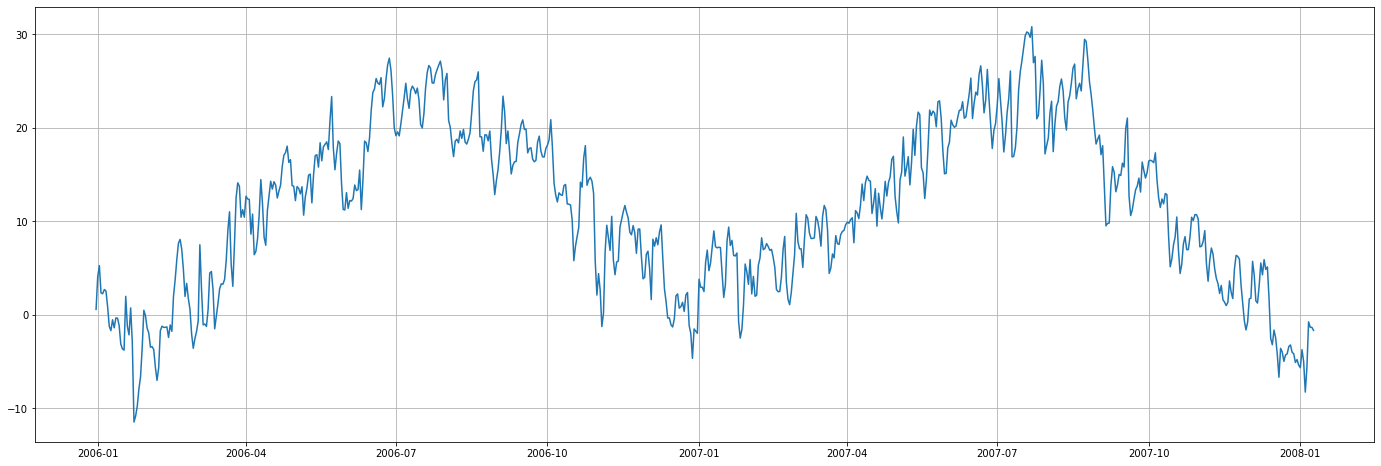

In [17]:
# Plotting approx. 2 years to have an idea about what we are working with.
plt.figure(figsize=(24,8))
plt.plot(swt_data["Temperature (C)"][:740])
plt.grid()
plt.show()

We see that there are a lot of spikes everywhere on the plot. This would increase complexity. <br>
So, I decided to apply rolling mean to reduce spikes.

In [18]:
ROLLING_MEAN_PARAMETER = 3
swt_data[["Temperature (C)","Apparent Temperature (C)","Humidity","Wind Speed (km/h)", "Wind Bearing (degrees)", "Visibility (km)", "Pressure (millibars)"]] = np.round(swt_data[["Temperature (C)","Apparent Temperature (C)","Humidity","Wind Speed (km/h)", "Wind Bearing (degrees)", "Visibility (km)", "Pressure (millibars)"]].rolling(ROLLING_MEAN_PARAMETER).mean(),3)
swt_data.dropna(inplace=True) # dropping the null days that are created by rolling mean

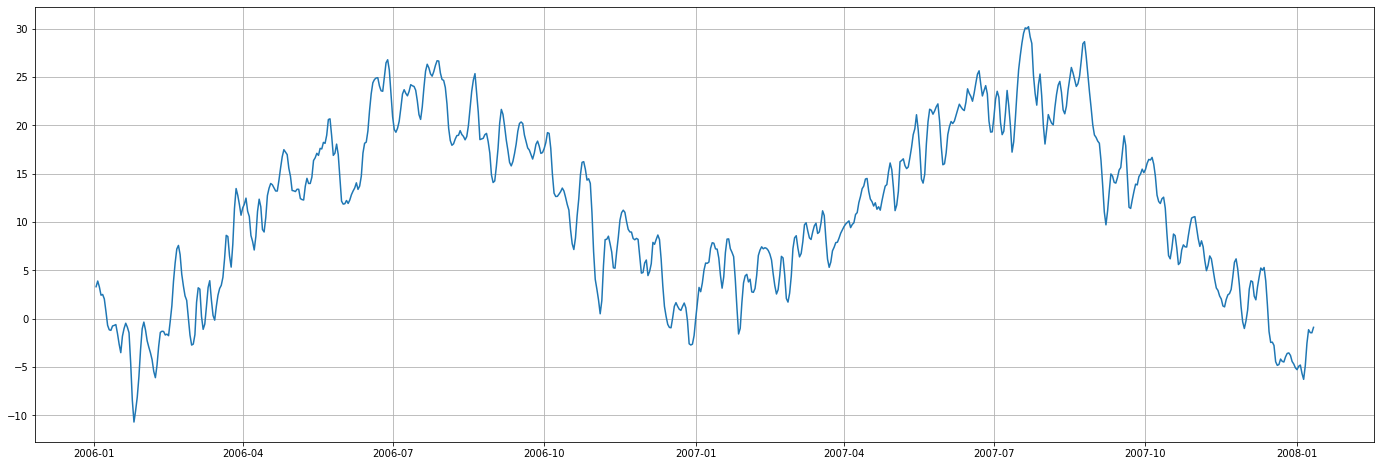

In [19]:
# Plotting approx. 2 years to have an idea about what we are working with after rolling mean
plt.figure(figsize=(24,8))
plt.plot(swt_data["Temperature (C)"][:740])
plt.grid()
plt.show()

As we see above, spikes are reduced dramatically. Therefore, it is much easier to learn a statistical model.

In [20]:
# Now I will design the dataset into more trainable sliding windows format.
N_DAYS_BEFORE = 10
swt_train = pd.DataFrame()

for day in range(N_DAYS_BEFORE-1,len(swt_data)):
    for i in reversed(range(1,N_DAYS_BEFORE)):
        for j in swt_data.columns:
            col_name = str(j) + " - " + str(i)
            swt_train.loc[day, col_name] = (swt_data[j][day-i])

In [21]:
# each row consist from previous 5 days with details.
swt_train.head()

,Temperature (C) - 9,Apparent Temperature (C) - 9,Humidity - 9,Wind Speed (km/h) - 9,Wind Bearing (degrees) - 9,Visibility (km) - 9,Pressure (millibars) - 9,Summary - 9,Temperature (C) - 8,Apparent Temperature (C) - 8,...,Pressure (millibars) - 2,Summary - 2,Temperature (C) - 1,Apparent Temperature (C) - 1,Humidity - 1,Wind Speed (km/h) - 1,Wind Bearing (degrees) - 1,Visibility (km) - 1,Pressure (millibars) - 1,Summary - 1
9,3.305,-0.805,0.851,18.723,149.111,9.941,1013.010,1.0,3.893,0.693,...,1033.416,1.0,-1.153,-2.135,0.825,4.764,210.681,8.383,1005.609,1.0
10,3.893,0.693,0.854,15.594,186.625,9.688,1014.513,1.0,3.285,0.530,...,1005.609,1.0,-1.206,-1.957,0.835,4.670,237.569,6.733,1004.573,1.0
11,3.285,0.530,0.884,12.568,150.708,8.690,1004.442,1.0,2.432,0.076,...,1004.573,1.0,-0.756,-1.391,0.866,4.503,216.153,5.118,1004.751,1.0
12,2.432,0.076,0.918,9.624,142.472,7.295,979.605,1.0,2.502,0.338,...,1004.751,1.0,-0.697,-1.925,0.902,5.447,203.278,3.466,1034.980,3.0
13,2.502,0.338,0.935,8.958,148.125,5.765,980.430,1.0,2.044,0.309,...,1034.980,3.0,-0.611,-2.305,0.901,6.018,172.986,4.059,1036.545,1.0


In [22]:
# first part of the shapes must be the same to labels.
print(swt_train.shape)

(4008, 72)


In [23]:
# Prepearing the labels for SWT task
# ignoring the first 4 days to match training data & only getting values so we won't have issues with date index later on.
swt_labels = swt_data["Temperature (C)"][9:].values
# first part of the shapes must be the same to train.
print(swt_labels.shape)

(4008,)


In [24]:
# Temperature (C) - 1  of 22th feature should be equal to the value of 23th label (today = tomorrow of yesterday)
print(" -- Features -- \n",swt_train.iloc[23])
print("\n -- Label -- \n", swt_labels[22])

 -- Features -- 
 Temperature (C) - 9              -10.693
Apparent Temperature (C) - 9     -14.088
Humidity - 9                       0.749
Wind Speed (km/h) - 9              8.332
Wind Bearing (degrees) - 9       122.611
                                  ...   
Wind Speed (km/h) - 1              6.950
Wind Bearing (degrees) - 1       262.361
Visibility (km) - 1                4.244
Pressure (millibars) - 1        1023.042
Summary - 1                        3.000
Name: 32, Length: 72, dtype: float64

 -- Label -- 
 -2.283


In [25]:
# Splitting train and test to be able to evaluate properly with some train test ratio.
swt_train_x, swt_test_x, swt_train_y, swt_test_y = train_test_split(swt_train,swt_labels, test_size=0.1)

In [26]:
# Checking the shapes for safety
print("shape of training dataset features: ",swt_train_x.shape)
print("shape of training dataset labels: ",swt_train_y.shape)
print("shape of testing dataset features: ",swt_test_x.shape)
print("shape of testing dataset labels: ",swt_test_y.shape)

shape of training dataset features:  (3607, 72)
shape of training dataset labels:  (3607,)
shape of testing dataset features:  (401, 72)
shape of testing dataset labels:  (401,)


## Sliding windows with multiple columns to predict next day's Daily Summary (SWS)

In [27]:
# Prepearing the labels for SWT task
# ignoring the first 4 days to match training data & only getting values so we won't have issues with date index later on.
sws_labels = swt_data["Summary"][9:].values
# first part of the shapes must be the same to train.
print(sws_labels.shape)

(4008,)


In [28]:
# splitting (75/25) as usual
sws_train_x, sws_test_x, sws_train_y, sws_test_y = train_test_split(swt_train, sws_labels, random_state=41, test_size=0.25)

In [29]:
sws_train_x

,Temperature (C) - 9,Apparent Temperature (C) - 9,Humidity - 9,Wind Speed (km/h) - 9,Wind Bearing (degrees) - 9,Visibility (km) - 9,Pressure (millibars) - 9,Summary - 9,Temperature (C) - 8,Apparent Temperature (C) - 8,...,Pressure (millibars) - 2,Summary - 2,Temperature (C) - 1,Apparent Temperature (C) - 1,Humidity - 1,Wind Speed (km/h) - 1,Wind Bearing (degrees) - 1,Visibility (km) - 1,Pressure (millibars) - 1,Summary - 1
934,22.055,21.913,0.656,15.473,218.944,11.914,1014.334,1.0,19.764,19.803,...,1014.109,1.0,16.940,16.940,0.714,12.248,278.750,12.310,1012.782,1.0
2775,26.341,26.513,0.589,11.400,204.722,12.083,1014.075,1.0,24.912,25.009,...,1016.761,1.0,27.043,26.714,0.522,5.518,157.014,15.887,1015.804,0.0
2958,-4.317,-6.101,0.863,6.085,170.833,4.394,1008.194,1.0,-3.338,-6.755,...,1022.747,1.0,-0.437,-3.628,0.803,10.970,140.333,10.695,1019.547,1.0
2790,23.556,23.180,0.504,8.759,212.736,14.772,1016.021,1.0,22.879,22.645,...,1016.808,1.0,22.109,22.095,0.672,11.584,256.417,14.531,1018.023,1.0
2525,5.864,4.442,0.915,8.122,80.750,6.457,1024.146,1.0,6.847,5.817,...,1004.355,1.0,9.031,7.692,0.840,16.953,200.667,11.927,1001.338,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,10.999,10.151,0.740,11.474,159.625,9.336,1022.024,1.0,10.042,8.977,...,1022.053,1.0,8.201,7.024,0.861,10.709,115.333,6.916,1025.261,0.0
1113,-8.337,-10.063,0.833,5.825,196.431,4.105,1034.290,3.0,-8.554,-9.785,...,1024.106,1.0,-0.448,-3.256,0.887,9.375,195.278,4.341,1023.320,3.0
3989,3.842,1.132,0.867,10.947,166.833,8.327,1019.156,1.0,3.692,0.943,...,1019.412,1.0,2.704,-0.262,0.879,11.055,171.667,7.851,1019.452,1.0
940,21.955,21.790,0.564,11.555,248.889,11.723,1014.258,1.0,20.066,19.935,...,1012.243,0.0,23.231,23.100,0.623,11.296,132.111,11.995,1014.943,1.0


In [30]:
# Checking the shapes for safety
print("shape of training dataset features: ",sws_train_x.shape)
print("shape of training dataset labels: ",sws_train_y.shape)
print("shape of testing dataset features: ",sws_test_x.shape)
print("shape of testing dataset labels: ",sws_test_y.shape)

shape of training dataset features:  (3006, 72)
shape of training dataset labels:  (3006,)
shape of testing dataset features:  (1002, 72)
shape of testing dataset labels:  (1002,)


## Sliding days as 1D Tempreture Arrays to predict next day's Temperature (SDT)

In [31]:
# For this approach I will only use 1 column. this will be the "Temperature (C)"
all_temps = swt_data["Temperature (C)"].values
train_temps = []
label_temps = []
for i in range(len(all_temps)-30):
    label_temps.append(all_temps[i+30])
    train_temps.append(all_temps[i:i+30])
    
train_temps = np.array(train_temps)
label_temps = np.array(label_temps)

In [32]:
# last of the tomorrow's array should be same as the today's label 
print(train_temps[45])
print(label_temps[44]) 

[-0.286  1.32   3.875  5.764  7.207  7.577  6.638  4.605  3.389  2.357
  1.898  0.087 -1.691 -2.733 -2.631 -1.655  1.689  3.196  3.056  0.228
 -1.103 -0.556  1.261  3.22   3.927  1.94   0.338 -0.153  1.271  2.432]
2.432


In [33]:
# Splitting the train and test 
sdt_train_x = train_temps[:-400]
sdt_test_x = train_temps[-400:]
sdt_train_y = label_temps[:-400]
sdt_test_y = label_temps[-400:]

In [34]:
# Checking the shapes for safety
print("shape of training dataset features: ",sdt_train_x.shape)
print("shape of training dataset labels: ",sdt_train_y.shape)
print("shape of testing dataset features: ",sdt_test_x.shape)
print("shape of testing dataset labels: ",sdt_test_y.shape)

shape of training dataset features:  (3587, 30)
shape of training dataset labels:  (3587,)
shape of testing dataset features:  (400, 30)
shape of testing dataset labels:  (400,)


## Machine Learning Models

* ### Random Forest Regressor

In [35]:
rf_model = RandomForestRegressor(max_depth=10)
rf_model.fit(swt_train_x,swt_train_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

* ### XGBoost

In [57]:
dtrain = xgb.DMatrix(sws_train_x, label=sws_train_y)
dtest = xgb.DMatrix(sws_test_x, label=sws_test_y)
param = {'max_depth': 4, 'eta': 0.05, 'objective': 'multi:softmax'}
param['eval_metric'] = "mlogloss"
param['num_class'] = 14
num_round = 400
evallist = [(dtest, 'test')]
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)
#model performs well.

[0]	test-mlogloss:2.36775
Will train until test-mlogloss hasn't improved in 10 rounds.
[1]	test-mlogloss:2.16938
[2]	test-mlogloss:2.01084
[3]	test-mlogloss:1.87939
[4]	test-mlogloss:1.76712
[5]	test-mlogloss:1.66968
[6]	test-mlogloss:1.58272
[7]	test-mlogloss:1.50542
[8]	test-mlogloss:1.43549
[9]	test-mlogloss:1.37143
[10]	test-mlogloss:1.31363
[11]	test-mlogloss:1.26016
[12]	test-mlogloss:1.21107
[13]	test-mlogloss:1.16547
[14]	test-mlogloss:1.12279
[15]	test-mlogloss:1.08313
[16]	test-mlogloss:1.04665
[17]	test-mlogloss:1.01254
[18]	test-mlogloss:0.98047
[19]	test-mlogloss:0.95000
[20]	test-mlogloss:0.92169
[21]	test-mlogloss:0.89523
[22]	test-mlogloss:0.86991
[23]	test-mlogloss:0.84601
[24]	test-mlogloss:0.82350
[25]	test-mlogloss:0.80235
[26]	test-mlogloss:0.78252
[27]	test-mlogloss:0.76374
[28]	test-mlogloss:0.74618
[29]	test-mlogloss:0.72959
[30]	test-mlogloss:0.71375
[31]	test-mlogloss:0.69855
[32]	test-mlogloss:0.68431
[33]	test-mlogloss:0.67052
[34]	test-mlogloss:0.65766
[35]

* ### Ridge Regression

In [37]:
lr_model = Ridge()
lr_model.fit(sdt_train_x,sdt_train_y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

## Evaluation and understanding predictions with XAI tools

* ### RF - SWT - SHAP

r_square score of the RandomForestRegressor model :  0.9835007029136892


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


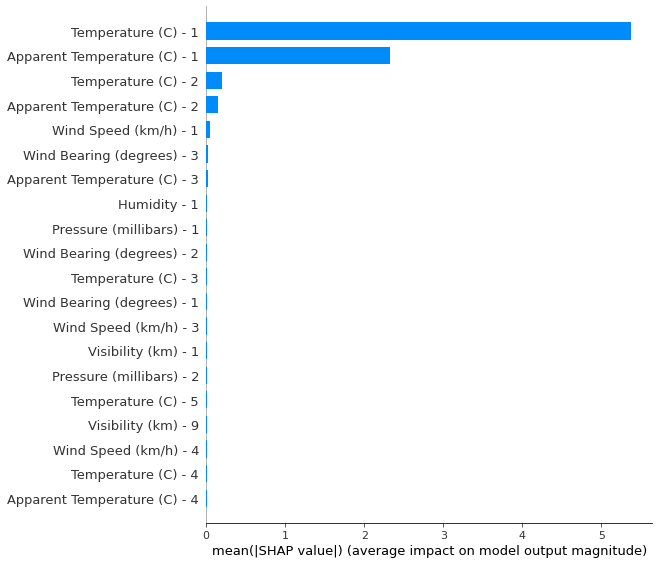

In [44]:
swt_pred_y = rf_model.predict(swt_test_x)
print("r_square score of the RandomForestRegressor model : ",r2_score(swt_test_y,swt_pred_y))   # the model performs really good.

# plotting a bar chart that explains the average impact per given column on predictions
shap_values = shap.TreeExplainer(rf_model).shap_values(swt_train_x)
shap.summary_plot(shap_values, swt_train_x, plot_type="bar");

In [ ]:
# Same Plot with more detailed style
shap.summary_plot(shap_values, swt_train_x)

In [ ]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(swt_train_x)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[10,:], swt_train_x.iloc[10,:])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values, swt_train_x)

In [ ]:
print("prediction : ",rf_model.predict(swt_test_x.iloc[77].values.reshape(1,72)))
print("ground truth : ",swt_test_y[77])

* ### XG - SWS - LIME

In [58]:
y_pred = bst.predict(dtest)
accuracy_score(y_pred, sws_test_y)

0.8772455089820359

In [ ]:
#explainer = lime.lime_tabular.LimeTabularExplainer(dtrain, feature_names=sws_train_x.columns.values.tolist(), verbose=True, mode='regression')

#expXGB = explainer.explain_instance(sws_train_x, bst.predict)
#expXGB.show_in_notebook(show_table=True) 

* ### LR - SDT - SHAP

In [46]:
sdt_pred_y = lr_model.predict(sdt_test_x)
print("r_square score of the Ridge Regression model : ",r2_score(sdt_test_y,sdt_pred_y))   # the model performs really good.

r_square score of the Ridge Regression model :  0.9933931846422718


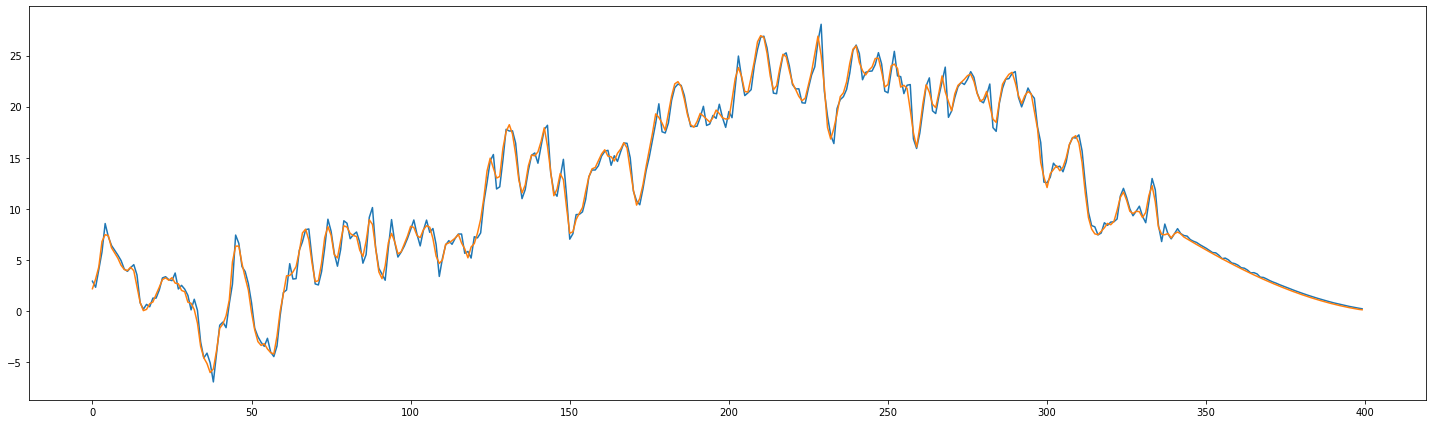

In [59]:
plt.figure(figsize=(20,6))
plt.plot(sdt_pred_y)
plt.plot(sdt_test_y)
plt.tight_layout()

In [48]:
# efe ergün